#1. Figure out your question

# 2. Obtain a labeled dataset (and explore its properties)

In [ ]:
#Import relevant libraries
from google.colab import drive
drive.mount('/content/gdrive')
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Mounted at /content/gdrive


In [ ]:
#Read in the data in the spreadsheet 
#df=pd.read_csv('/content/gdrive/My Drive/Econ 484/Term Project/MCA Placement Data.csv')
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Copy of MCA Placement Data.csv')
#print out the first few rows of data with the variable names
pd.set_option('display.max_columns', None)
print("Shape: {}".format(str(df.shape)))
#print out the number of observations and variables in the dataset
df.head()

Shape: (259, 11)


,ID,Gender,Year,Business?,Double Major?,Minor?,Internship?,Firm Category,Location,ACT,GPA
0,1,0,2021,1,0,1,1.0,1,Dallas,25.0,3.96
1,2,1,2021,0,0,1,1.0,1,Houston,33.0,3.96
2,3,0,2021,1,0,0,1.0,1,Houston,30.0,3.95
3,4,0,2021,0,0,0,1.0,1,Dallas,33.0,3.94
4,5,0,2021,1,0,1,1.0,1,Austin,35.0,4.00


In [ ]:
# display the type of the columns in the data
pd.set_option('display.max_rows', None)
types = pd.DataFrame(df.dtypes[df.columns])
pd.DataFrame.transpose(types)

,ID,Gender,Year,Business?,Double Major?,Minor?,Internship?,Firm Category,Location,ACT,GPA
0,int64,int64,int64,int64,int64,int64,float64,int64,object,float64,float64


In [ ]:
# get summary statistics on the numeric values in the dataset
df.describe()

,ID,Gender,Year,Business?,Double Major?,Minor?,Internship?,Firm Category,ACT,GPA
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,162.000000,259.000000,189.000000,214.000000
mean,130.000000,0.142857,2015.972973,0.575290,0.054054,0.362934,0.382716,0.478764,31.365079,3.859813
std,74.911058,0.350605,3.593065,0.495256,0.226562,0.481777,0.487557,0.500516,2.878580,0.147094
min,1.000000,0.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,3.080000
25%,65.500000,0.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,3.810000
50%,130.000000,0.000000,2016.000000,1.000000,0.000000,0.000000,0.000000,0.000000,32.000000,3.910000
75%,194.500000,0.000000,2019.000000,1.000000,0.000000,1.000000,1.000000,1.000000,33.000000,3.960000
max,259.000000,1.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,4.000000


In [ ]:
#the location column is an object; get value counts for locations
for c in df.columns:
    if df[c].dtype == object:
      print(df[c].value_counts())
      print(sum(df[c].value_counts()))

Dallas            86
Los Angeles       29
Salt Lake City    24
Houston           21
San Francisco     19
Washington DC     16
Cleveland         11
Seattle            8
Boston             8
Chicago            5
Denver             5
New York City      4
Atlanta            3
Sacramento         2
Austin             2
Tokyo              2
Cambridge          2
San Jose           1
Phoenix            1
Johannesberg       1
Toronto            1
Portland           1
Name: Location, dtype: int64
252


In [ ]:
#Determine the number of missing values for each column
missing = []
b = sum(df['ID'].value_counts())
for c in df.columns:
    a = sum(df[c].value_counts())
    z = b - a
    missing.append(z)
missingvars = pd.DataFrame(pd.DataFrame(np.array(missing)).transpose())
names = [s + 'Missing' for s in df.columns]
missingvars.columns=names
missingvars = missingvars.drop(columns=missingvars.columns[(missingvars == 0).any()])
missingvars

,Internship?Missing,LocationMissing,ACTMissing,GPAMissing
0,97,7,70,45


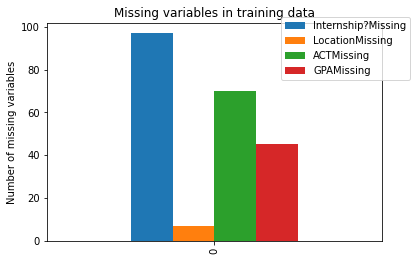

In [ ]:
#plot the number of missing variables
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
missingvars.plot.bar(ax=ax)
ax.set_title("Missing variables in training data")
ax.set_ylabel("Number of missing variables")
ax.set_xlabel("")
 
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
# impute indicators for columns with missing values
from sklearn.impute import MissingIndicator
indicator = MissingIndicator()
indicator.fit(df)
df1 = pd.DataFrame(indicator.transform(df))
df1.columns=missingvars.columns
df1.head()

,Internship?Missing,LocationMissing,ACTMissing,GPAMissing
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


In [ ]:
#since I've now created an indicator for each missing value, I now replace all NA with 0
print('before', df.isnull().sum().sum(),' Nan values')
df.fillna(0, inplace=True)
print('after',df.isnull().sum().sum(),' Nan values')

before 219  Nan values
after 0  Nan values


In [ ]:
#split into outcome variable and explanatory variables
#do not include ID variable (unnecessary)
y=df.loc[:,'Firm Category']
x=df.loc[:,[x for x in df.columns if x not in ('ID','Firm Category')]]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


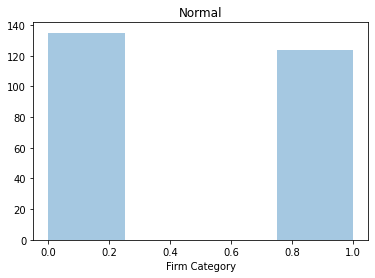

In [ ]:
#explore the y variable distribution; 0 is "non-MBB", 1 is "MBB"
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False)

In [ ]:
#"Pre-process" quantitative features by standardizing them to have zero mean and unit variance
from sklearn.preprocessing import StandardScaler
xquant = df.loc[:,['ACT','GPA']]
scaler = StandardScaler()
scaler.fit(xquant)
xquant_scaled = pd.DataFrame(scaler.transform(xquant),columns=xquant.columns)
for c in xquant_scaled.columns:
  x[c] = xquant_scaled[c].values
x.head(1)

,Gender,Year,Business?,Double Major?,Minor?,Internship?,Location,ACT,GPA
0,0,2021,1,0,1,1.0,Dallas,0.149325,0.524891


In [ ]:
#turn years into an object variable to enable getting a dummy variable for each year to control for time-bound effects
x.astype({'Year': 'str'}).dtypes

Gender             int64
Year              object
Business?          int64
Double Major?      int64
Minor?             int64
Internship?      float64
Location          object
ACT              float64
GPA              float64
dtype: object

In [ ]:
#generate indicator variables for location
x = pd.get_dummies(x, columns=['Year','Location'])
print(x.shape)
x

(259, 43)


,Gender,Business?,Double Major?,Minor?,Internship?,ACT,GPA,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Location_0,Location_Atlanta,Location_Austin,Location_Boston,Location_Cambridge,Location_Chicago,Location_Cleveland,Location_Dallas,Location_Denver,Location_Houston,Location_Johannesberg,Location_Los Angeles,Location_New York City,Location_Phoenix,Location_Portland,Location_Sacramento,Location_Salt Lake City,Location_San Francisco,Location_San Jose,Location_Seattle,Location_Tokyo,Location_Toronto,Location_Washington DC
0,0,1,0,1,1.0,0.149325,0.524891,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1.0,0.714957,0.524891,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1.0,0.502845,0.518081,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1.0,0.714957,0.511272,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1.0,0.856365,0.552129,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,1.0,0.714957,0.545320,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0.0,0.785661,0.518081,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,1.0,0.573549,0.552129,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,1.0,0.573549,0.497652,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,1.0,-1.618276,0.361461,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#add in the indicators for missing variables
for c in df1.columns:
  #convert missing indicator boolean to integer
  df1[c] = df1[c]*1
  #add column to original dataframe
  x[c] = pd.Series(df1[c])
original_columns = x.columns
x.shape

(259, 47)

In [ ]:
# Get correct covariates (X) and variable of interest (d)
X = x.drop(['Business?'], axis=1)
d = x['Business?']

In [ ]:
#generate polynomial features and interaction terms for all x variables
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
xpoly = poly.fit_transform(X)
column_names = poly.get_feature_names(X.columns)
X = pd.DataFrame(xpoly,columns=column_names, index=y.index)
X.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(259, 1128)

#3. Pick an appropriate method

##4. Divide into training and test sets 

In [ ]:
from sklearn.model_selection import train_test_split
X_1, X_2, d_1, d_2, y_1, y_2 = train_test_split(X, d, y, test_size=0.2, random_state=42)

##5, 6. Choose regularization parameters via cross-validation on the training set and fit model on the whole training set using the cross-validated parameters

In [ ]:
from sklearn.metrics import mean_squared_error # For comparing ML prediction methods
import statsmodels.api as sm # For outputting std errors, t-stats, and confidence intervals of final regression coefficients

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Post Double Selection

In [ ]:
# Step 1: Lasso the outcome on X
lassoy = linear_model.Lasso(alpha=0.1, max_iter=100000,random_state=42).fit(X_1, y_1)
# print("Lassoy optimal alpha:", lassoy.alpha_)
print("CV lassoy alpha was ~0.01, which was too small. We set alpha=0.1 to remove enough covariates.")

# get MSE on test set
pds_test_preds_y = lassoy.predict(X_2)
print('Lassoy test MSE: %.2f' % mean_squared_error(y_2, pds_test_preds_y))

# Step 2: Lasso the treatment on X
lassod = linear_model.Lasso(alpha=0.1, max_iter=100000,random_state=42).fit(X_1, d_1)
# print("Lassod optimal alpha:", lassoy.alpha_)
print("CV lassod alpha was ~0.01, which was too small. We set alpha=0.1 to remove enough covariates.")

# get MSE on test set
pds_test_preds_d = lassod.predict(X_2)
print('Lassod test MSE: %.2f' % mean_squared_error(d_2, pds_test_preds_d))

# Step 3: Form the union of controls
Xunion = X_1.iloc[:,(lassod.coef_!=0) + (lassoy.coef_!=0)]

# Step 4: Concatenate treatment with union of controls and regress y on that
rhs=pd.concat([d_1,Xunion],axis=1)
fullreg=linear_model.LinearRegression().fit(rhs,y_1)
print("PDS regression effect of selective college: {:.3f}".format(fullreg.coef_[0]))

reg_obj = sm.OLS(y_1,sm.add_constant(rhs))
results = reg_obj.fit()
se_pds = results.bse[1]

print(results.summary())

CV lassoy alpha was ~0.01, which was too small. We set alpha=0.1 to remove enough covariates.
Lassoy test MSE: 0.23
CV lassod alpha was ~0.01, which was too small. We set alpha=0.1 to remove enough covariates.
Lassod test MSE: 0.24
PDS regression effect of selective college: -0.248
                            OLS Regression Results                            
Dep. Variable:          Firm Category   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     12.21
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.22e-07
Time:                        06:06:42   Log-Likelihood:                -132.87
No. Observations:                 207   AIC:                             273.7
Df Residuals:                     203   BIC:                             287.1
Df Model:                           3                                         
Covari

## Double Debiased Machine Learning (Support Vector Machines)



In [ ]:
# Import the SVC package that allows for nonlinear decision boundaries and imperfect separation.
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
  # define grid for parameters
param_grid = {'C': [.01,.05,.1, .15,.2,.3,.4,.5,1],'gamma': [1,1.1,1.2,1.3,1.5,1.7,2,2.5],'kernel':['rbf','poly','linear']} #try every combo of these three parameters and see which is the best
grid_search = GridSearchCV(SVC(random_state=42),param_grid,cv=5,return_train_score=True)
best_SVCy=grid_search.fit(X_1,y_1)
best_SVCd=grid_search.fit(X_1,d_1)

print("Best C for y: ",best_SVCy.best_estimator_.get_params()['C'])
print("Best gamma for y: ",best_SVCy.best_estimator_.get_params()['gamma'])
print("Best kernel for y: ",best_SVCy.best_estimator_.get_params()['kernel'])

print("Best C for d: ",best_SVCd.best_estimator_.get_params()['C'])
print("Best gamma for d: ",best_SVCd.best_estimator_.get_params()['gamma'])
print("Best kernel for d: ",best_SVCd.best_estimator_.get_params()['kernel'])

Best C for y:  0.1
Best gamma for y:  1
Best kernel for y:  linear
Best C for d:  0.1
Best gamma for d:  1
Best kernel for d:  linear


In [ ]:
SVCy = SVC(C=0.1,kernel='linear',gamma=1)
SVCd = SVC(C=0.1,kernel='linear',gamma=1)

In [ ]:
# create our sample splitting "object"
kf = KFold(n_splits=5,shuffle=True,random_state=42)

# apply the splits to our Xs
kf.get_n_splits(X_1)

# initialize array to hold each fold's regression coefficient
coeffs=np.zeros(5)

# initialize arrays to hold each fold's MSEs
SVM_mse_y=np.zeros(5)
SVM_mse_d=np.zeros(5)

# Now loop through each fold
ii=0 # counter that keeps track of what fold we're on
total_variance = 0 # keep track of total variance to get std err of averaged coefficient
for train_index, test_index in kf.split(X_1):
  X_train, X_test = X_1.iloc[train_index,:], X_1.iloc[test_index,:] # using iloc to pick which obs. we want
  y_train, y_test = y_1.iloc[train_index], y_1.iloc[test_index]
  d_train, d_test = d_1.iloc[train_index], d_1.iloc[test_index]
  # Do DDML thing
  # SVC y on training folds:
  SVCy.fit(X_train,y_train)

  # get residuals in test set
  yresid=y_test-SVCy.predict(X_test)

  # get MSE on test set
  SVM_mse_y[ii] = mean_squared_error(y_2, SVCy.predict(X_2))
  
  #SVC d on training folds
  SVCd.fit(X_train,y_train)

  # get residuals in test set
  dresid=d_test-SVCd.predict(X_test)

  # get MSE on test set
  SVM_mse_d[ii] = mean_squared_error(d_2, SVCd.predict(X_2))

  # regress resids on resids
  reg_obj = sm.OLS(yresid,dresid)
  results = reg_obj.fit()
  # print(results.bse)
  total_variance += results.bse ** 2

  # save coefficient in a vector
  coeffs[ii]=results.params[0]
  ii+=1

# calculate the standard errors
stande_svc=np.sqrt(total_variance / 5)

# Take the average of the regression coefficients
coeffs_svc = np.mean(coeffs)
print("Double-Debiased Machine Learning effect of being a business major: {:.3f}".format(coeffs_svc))
print('coefficients:', coeffs)
print("Standard Error of mean coefficient:", np.sqrt(total_variance / 5)) # avg std err = add up variances, divide by 5, take square root

Double-Debiased Machine Learning effect of being a business major: 0.127
coefficients: [0.         0.28       0.04347826 0.27272727 0.03846154]
Standard Error of mean coefficient: Business?    0.088728
dtype: float64


# Double Debiased Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#parameters grid for cross-validation of the regression of y on x
parameters_y = {'max_depth':range(2,6),'min_samples_leaf':range(1,4),
              'criterion': ["gini", "entropy"]} 
#reg y_train subsample on X_train
rfcv_y= GridSearchCV(RandomForestClassifier(random_state=42), 
                     parameters_y, n_jobs=5).fit(X=X_train,y=y_train)

#unpacked cross-validated parameters 
rfy = RandomForestClassifier(random_state=42,**rfcv_y.best_params_)
print("RF_y optimal parameters", rfcv_y.best_params_)

#parameters grid for cross-validation of the regression of d on x
parameters_d = {'max_depth':range(2,6),'min_samples_leaf':range(1,4),
              'criterion': ["gini", "entropy"]} 
rfcv_d= GridSearchCV(RandomForestClassifier(random_state=42), 
                     parameters_d, n_jobs=5).fit(X=X_train,y=d_train)
rfd = RandomForestClassifier(random_state=42,**rfcv_d.best_params_)  

print("RF_d optimal parameters", rfcv_d.best_params_)

RF_y optimal parameters {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1}
RF_d optimal parameters {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}


Evaluate using Sample Splitting

In [ ]:
# initialize arrays to hold each fold's MSEs
RF_mse_y=np.zeros(5)
RF_mse_d=np.zeros(5)

#loop through each fold
ii=0 #keeps track of what fold we're on
total_variance = 0 #to get std err of averaged coefficient
for train_index, test_index in kf.split(X_1):
  X_train, X_test = X_1.iloc[train_index,:], X_1.iloc[test_index,:] # using iloc to pick which obs. we want
  y_train, y_test = y_1.iloc[train_index], y_1.iloc[test_index]
  d_train, d_test = d_1.iloc[train_index], d_1.iloc[test_index]
  
  # DDML
  rfy.fit(X_train, y_train)
  #y residuals in test
  yresidrf = y_test - rfy.predict(X_test)

  # get residuals in test set
  test_preds_y_rf = rfy.predict(X_2)
 
  #MSE on test set
  RF_mse_y[ii] = mean_squared_error(y_2, test_preds_y_rf)

  #Random Forest d on training folds
  rfd.fit(X_train, d_train)
  
  #d residuals in test set
  dresidrf = d_test - rfd.predict(X_test)
  #MSE
  test_preds_drf = rfd.predict(X_2)
  RF_mse_d[ii] = mean_squared_error(d_2, test_preds_drf)

#OLS residuals on residuals
  ddmlregrf = linear_model.LinearRegression().fit(dresidrf.values.reshape(-1,1),yresidrf)

  reg_obj = sm.OLS(yresidrf,dresidrf)
  results = reg_obj.fit()
  total_variance += results.bse ** 2 

  # save coefficient in a vector
  coeffs[ii]=ddmlregrf.coef_[0]
  ii+=1
#average coefficient among all estimations for use in aggregated table
coeffs_rf = np.mean(coeffs)

#standard error
se_rf = np.sqrt(total_variance / 5)

print("DDML Random Forests effect of business major: {:.3f}".format(np.mean(coeffs)))
print("Standard Error of mean coefficient:", np.sqrt(total_variance / 5))


DDML Random Forests effect of business major: -0.094
Standard Error of mean coefficient: Business?    0.133567
dtype: float64


# Causal Forest for Determining Heterogeneous Effects

The following describe feature importances indicating the level of heterogeneity created by the treatment Business Major, showing relative importance to the given subclass. Larger numbers indicate more significance. In this case, Having a business major creates greater heterogeneity between years some on those with a minor, and less among those with an internship. This does not imply magnitude of the effect. 

In [ ]:
#specific library for Causal Forest
!pip install econml

     |████████████████████████████████| 3.1 MB 9.0 MB/s 
     |████████████████████████████████| 356 kB 58.1 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 123 kB 61.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491646 sha256=fdfd445b9b72f2a824a66055a91087923c677963ee35d3e57d393d5be1599ee6
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
from econml.dml import CausalForestDML as CausalForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#establishing a list of potentially hetergenous variables
feature_names = ['Gender',
                 'Year',
                 'Double Major?','Minor?',
                    'Internship?']
#adding the controls follows an assumption of uncoundedness and removes two
#                     variables from being scored as affected by the business major
controls = ['ACT','GPA']

train, test = train_test_split(df,test_size=0.2)

#Run the estimator using the Random Forest Classifier to create a Propensity Tree
#since the goal is to check for heterogeneity rahter than identify specific effect, 
#default parameters are used.
estimator = CausalForest(n_estimators=1000,
                         cv = 5,
                         discrete_treatment = True,
                         model_t=RandomForestClassifier(random_state = 42),
                         model_y=RandomForestClassifier(random_state = 42),
                         )
#Fitting tree to the response
estimator.fit(train['Firm Category'],
              train['Business?'], #treatment: whether in business major 
              X = train[feature_names],
              inference='blb', #bootstrap of little bags inference
              W = train[controls])
effects_train = estimator.effect(train[feature_names]) #effects on training model
effects_test = estimator.effect(test[feature_names]) #effects on test model
conf_intrvl = estimator.effect_interval(test[feature_names]) #confidence interval 
#for all coefficient estimations

#prints the scores on level of heterogeneity created by the business major among 
#each feature in the order of the feature list. 
print(estimator.feature_importances())
print("creates higher heterogeneity among those with a minor and between years")


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


[0.01961916 0.75631244 0.         0.15542524 0.06864315]
creates higher heterogeneity among those with a minor and between years


The second feature, year, has a significantly higher level of heterogeneity than all other features. 

Identify the relative magnitudes of heterogeneity for "minor?" to determine if effect corroborates with other methods.

In [ ]:
#effect of business major for those with a minor
minorfx_train=effects_train[train['Double Major?'].values==1]
minorbusi_train=train['Business?'].iloc[train['Double Major?'].values==1] 
print('Training effect of business major for those with a minor', minorfx_train.mean())

#effect of business major for those without a minor
nominorfx_train=effects_train[train['Minor?'].values==0]
nominorbusi_train=train['Business?'].iloc[train['Minor?'].values==0] 
print('Training effect of business major for those without a minor', nominorfx_train.mean())


Training effect of business major for those with a minor -0.023939387862099155
Training effect of business major for those without a minor -0.07882314407143373


Effect seems very small, especially in comparison to other methods (though it is unkown if statstically significant or not). 

In [ ]:
#MSE of estimator to compare to the other models 
print('Causal Forest MSE:', estimator.score(test['Firm Category'], test['Business?'], X = test[feature_names], W = test[controls]))

Causal Forest MSE: 0.2003011449609216


# Double Debiased Machine Learning (LASSO)

In [ ]:
'''Without Sample Splitting first'''

# Lasso y on x
lassoy = linear_model.LassoCV(max_iter=100000,random_state=42).fit(X_1, y_1)
print("Lasso_y optimal alpha:", lassoy.alpha_)
# Obtain residuals
yresid = y_1 - lassoy.predict(X_1)
# Get test set MSE of predicting y
test_preds_y = lassoy.predict(X_2)
print('Lasso_y test MSE: %.2f' % mean_squared_error(y_2, test_preds_y))

# Lasso d on x
lassod = linear_model.LassoCV(max_iter=100000,random_state=42).fit(X_1, d_1)
print("Lasso_d optimal alpha:", lassod.alpha_)
# Obtain residuals
dresid = d_1 - lassod.predict(X_1)
# Get test set MSE of predicting d 
test_preds_d = lassod.predict(X_2)
print('Lasso_d test MSE: %.2f' % mean_squared_error(d_2, test_preds_d))

# Regress y residuals on d residuals
ddmlreg_lasso = linear_model.LinearRegression().fit(dresid.values.reshape(-1,1), yresid)
print("Double-Debiased Machine Learning (LASSO) effect of business major:", ddmlreg_lasso.coef_[0])

# Same thing but with statsmodel for regression table summary
reg_obj = sm.OLS(yresid,sm.add_constant(dresid))
results = reg_obj.fit()

print(results.summary())

Lasso_y optimal alpha: 0.010379040522645253
Lasso_y test MSE: 0.15
Lasso_d optimal alpha: 0.009625896227602881
Lasso_d test MSE: 0.20
Double-Debiased Machine Learning (LASSO) effect of business major: -0.16114000681920554
                            OLS Regression Results                            
Dep. Variable:          Firm Category   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.399
Date:                Thu, 09 Dec 2021   Prob (F-statistic):             0.0122
Time:                        06:11:10   Log-Likelihood:                -76.117
No. Observations:                 207   AIC:                             156.2
Df Residuals:                     205   BIC:                             162.9
Df Model:                           1                                         
Covariance Type:            nonrobust                              

In [ ]:
'''With sample splitting'''
import statsmodels.api as sm

# create our sample splitting "object"
kf = KFold(n_splits=5,shuffle=True,random_state=42)

# apply the splits to our Xs
kf.get_n_splits(X_1)

# initialize array to hold each fold's regression coefficient
coeffs=np.zeros(5)
mse_y=np.zeros(5)
mse_d=np.zeros(5)

lassoy = linear_model.Lasso(alpha=lassoy.alpha_, max_iter=100000)
lassod = linear_model.Lasso(alpha=lassod.alpha_,max_iter=100000)

# Now loop through each fold
ii=0
total_variance = 0 # keep track of total variance to get std err of averaged coefficient
for train_index, test_index in kf.split(X_1):
  X_train, X_test = pd.DataFrame(X_1).iloc[train_index,:], pd.DataFrame(X_1).iloc[test_index,:]
  y_train, y_test = y_1.iloc[train_index], y_1.iloc[test_index]
  d_train, d_test = d_1.iloc[train_index], d_1.iloc[test_index]
  # Do DDML thing
  # Lasso y on training folds:
  lassoy.fit(X_train, y_train)

  # but get residuals in test set
  yresid = y_test - lassoy.predict(X_test)

  # get MSE on held-out set
  test_preds_y = lassoy.predict(X_2)
  mse_y[ii] = mean_squared_error(y_2, test_preds_y)
  
  # Lasso d on training folds
  lassod.fit(X_train, d_train)

  #but get residuals in test set
  dresid = d_test - lassod.predict(X_test)

  # get MSE on held-out set
  test_preds_d = lassod.predict(X_2)
  mse_d[ii] = mean_squared_error(d_2, test_preds_d)

  # regress resids on resids
  ddmlreg = linear_model.LinearRegression().fit(dresid.values.reshape(-1,1),yresid)

  reg_obj = sm.OLS(yresid,dresid)
  results = reg_obj.fit()
  # print(results.bse)
  total_variance += results.bse ** 2

  # save coefficient in a vector
  coeffs[ii]=ddmlreg.coef_[0]
  ii+=1

LASSO_mse_y = mse_y
LASSO_mse_d = mse_d
# Take average
print("Double-Debiased Machine Learning (LASSO) effect of business major: {:.3f}".format(np.mean(coeffs)))
coef_lasso = np.mean(coeffs)
print("Standard Error of mean coefficient:", np.sqrt(total_variance / 5)) # avg std err = add up variances, divide by 5, take square root
se_lasso = np.sqrt(total_variance / 5)
print("coeffs:", coeffs)
print("MSE_y", mse_y)
print("Avg:", np.mean(mse_y))
print("MSE_d", mse_d)
print("Avg:", np.mean(mse_d))

Double-Debiased Machine Learning (LASSO) effect of business major: -0.146
Standard Error of mean coefficient: Business?    0.143345
dtype: float64
coeffs: [-0.53097133  0.09583588 -0.12086348  0.00753029 -0.18045305]
MSE_y [0.15689284 0.14574473 0.15001512 0.15846138 0.15489113]
Avg: 0.15320104191951614
MSE_d [0.2065725  0.20476055 0.19417019 0.21815292 0.19403697]
Avg: 0.20353862312526805


# Double Debiased Machine Learning (Logit)

In [ ]:
'''Without Sample Splitting first'''

from sklearn.linear_model import LogisticRegression

# Logistic regression of y on x
logity = linear_model.LogisticRegressionCV(max_iter=1000,random_state=42).fit(X_1, y_1)
print("Logit optimal C:", logity.C_)
# Obtain residuals
yresid = y_1 - logity.predict(X_1)
# Get test set MSE of predicting y
logit_test_preds_y = logity.predict(X_2)
print('Logity test MSE: %.2f' % mean_squared_error(y_2, logit_test_preds_y))

# Logistic regression of d on x
logitd = linear_model.LogisticRegressionCV(max_iter=1000,random_state=42).fit(X_1, d_1)
print("Logit optimal C:", logitd.C_)
# Obtain residuals
dresid = d_1 - logitd.predict(X_1)
# Get test set MSE of predicting d 
logit_test_preds_d = logitd.predict(X_2)
print('Logitd test MSE: %.2f' % mean_squared_error(d_2, logit_test_preds_d))

# Regress y residuals on d residuals
ddmlreg_logit = linear_model.LinearRegression().fit(dresid.values.reshape(-1,1), yresid)
print("Double-Debiased Machine Learning (Logit) effect of business major:", ddmlreg_logit.coef_[0])

# Same thing but with statsmodel for regression table summary
import statsmodels.api as sm
reg_obj = sm.OLS(yresid,sm.add_constant(dresid))
results = reg_obj.fit()

print(results.summary())

Logit optimal C: [0.35938137]
Logity test MSE: 0.21
Logit optimal C: [2.7825594]
Logitd test MSE: 0.31
Double-Debiased Machine Learning (Logit) effect of business major: -0.3807506053268768
                            OLS Regression Results                            
Dep. Variable:          Firm Category   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     18.58
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.53e-05
Time:                        06:11:19   Log-Likelihood:                -5.3740
No. Observations:                 207   AIC:                             14.75
Df Residuals:                     205   BIC:                             21.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coe

In [ ]:
'''With sample splitting'''
import statsmodels.api as sm

# create our sample splitting "object"
kf = KFold(n_splits=5,shuffle=True,random_state=42)

# apply the splits to our Xs
kf.get_n_splits(X_1)

# initialize array to hold each fold's regression coefficient
coeffs=np.zeros(5)
mse_y=np.zeros(5)
mse_d=np.zeros(5)

logity = linear_model.LogisticRegression(C=logity.C_[0], max_iter=1000)
logitd = linear_model.LogisticRegression(C=logitd.C_[0], max_iter=1000)

# Now loop through each fold
ii=0
total_variance = 0 # keep track of total variance to get std err of averaged coefficient
for train_index, test_index in kf.split(X_1):
  X_train, X_test = pd.DataFrame(X_1).iloc[train_index,:], pd.DataFrame(X_1).iloc[test_index,:]
  y_train, y_test = y_1.iloc[train_index], y_1.iloc[test_index]
  d_train, d_test = d_1.iloc[train_index], d_1.iloc[test_index]
  # Do DDML thing
  # Lasso y on training folds:
  logity.fit(X_train, y_train)

  # but get residuals in test set
  yresid = y_test - logity.predict(X_test)

  # get MSE on held-out set
  test_preds_y = logity.predict(X_2)
  mse_y[ii] = mean_squared_error(y_2, test_preds_y)
  
  # Lasso d on training folds
  logitd.fit(X_train, d_train)

  #but get residuals in test set
  dresid = d_test - logitd.predict(X_test)

  # get MSE on held-out set
  test_preds_d = logitd.predict(X_2)
  mse_d[ii] = mean_squared_error(d_2, test_preds_d)

  # regress resids on resids
  ddmlreg = linear_model.LinearRegression().fit(dresid.values.reshape(-1,1),yresid)

  reg_obj = sm.OLS(yresid,dresid)
  results = reg_obj.fit()
  # print(results.bse)
  total_variance += results.bse ** 2

  # save coefficient in a vector
  coeffs[ii]=ddmlreg.coef_[0]
  ii+=1

# Take average
print("Double-Debiased Machine Learning (Logit) effect of business major: {:.3f}".format(np.mean(coeffs)))
coef_logit = np.mean(coeffs)
print("Standard Error of mean coefficient:", np.sqrt(total_variance / 5)) # avg std err = add up variances, divide by 5, take square root
se_logit = np.sqrt(total_variance / 5)
print("coeffs:", coeffs)
print("MSE_y", mse_y)
print("Avg:", np.mean(mse_y))
logit_mse_y = np.mean(mse_y)
print("MSE_d", mse_d)
print("Avg:", np.mean(mse_d))
logit_mse_d = np.mean(mse_d)

Double-Debiased Machine Learning (Logit) effect of business major: -0.105
Standard Error of mean coefficient: Business?    0.118517
dtype: float64
coeffs: [-0.29593268  0.07425743 -0.15648855 -0.05905512 -0.08969466]
MSE_y [0.23076923 0.19230769 0.21153846 0.25       0.23076923]
Avg: 0.2230769230769231
MSE_d [0.28846154 0.26923077 0.30769231 0.32692308 0.23076923]
Avg: 0.2846153846153846


# Choose a model of best fit

Compare the results of each method

In [ ]:
# Gather all test MSES for predicting y and d
SVM_y = np.mean(SVM_mse_y)
SVM_d = np.mean(SVM_mse_d)
logit_y = logit_mse_y
logit_d = logit_mse_d
PDSlasso_y = mean_squared_error(y_2, pds_test_preds_y)
PDSlasso_d = mean_squared_error(d_2, pds_test_preds_d)
lasso_y = np.mean(LASSO_mse_y)
lasso_d = np.mean(LASSO_mse_d)
rf_y = np.mean(RF_mse_y)
rf_d = np.mean(RF_mse_d)

# Gather coefficient results
coeffs_pds = fullreg.coef_[0]
coeffs_logit = coef_logit
coeffs_lasso = coef_lasso

#convert all se from series into scalers
se_svc = stande_svc.tolist()
se_logit = se_logit.tolist()
se_lasso = se_lasso.tolist()
se_rf = se_rf.tolist()
se_pds = np.mean(se_pds.tolist())

# Generate table of results
data = {'Model': ['DDB SVC', 'DDB Logit',
                  'DDB LASSO', 'DDB Random Forests', 
                  'PDS LASSO'],
        'MSE_y': [SVM_y, logit_y, lasso_y, rf_y, PDSlasso_y ],
        'MSE_d': [SVM_d,logit_d, lasso_d,rf_d, PDSlasso_d],
        
        'Coefficient Effect': [coeffs_svc, coeffs_logit, 
                               coeffs_lasso, coeffs_rf, coeffs_pds],
        'Coeff SE': [se_svc, se_logit, se_lasso,se_rf, se_pds]}

method_comp = pd.DataFrame(data = data)
method_comp

,Model,MSE_y,MSE_d,Coefficient Effect,Coeff SE
0,DDB SVC,0.161538,0.496154,0.126933,[0.08872833430716096]
1,DDB Logit,0.223077,0.284615,-0.105383,[0.11851734889016859]
2,DDB LASSO,0.153201,0.203539,-0.145784,[0.14334505565002217]
3,DDB Random Forests,0.215385,0.350000,-0.093989,[0.13356665453578784]
4,PDS LASSO,0.233280,0.237779,-0.248038,0.0749852


In [ ]:
method_comp.to_excel('/content/gdrive/My Drive/Colab Notebooks/output.xlsx')

Select the models of best fit for both y and d

In [ ]:
# Predict y using LASSO
lasso_y = linear_model.LassoCV(max_iter=100000,random_state=42).fit(X_1, y_1)
print("Lasso  y optimal alpha:", lasso_y.alpha_)
yresid = y_1 - lasso_y.predict(X_1)
logit_test_preds_y = lasso_y.predict(X_2)
print('Lasso y MSE: %.2f' % mean_squared_error(y_2, logit_test_preds_y))

# Predict d using LASSO
lassod = linear_model.LassoCV(max_iter=100000,random_state=42).fit(X_1, d_1)
print("Lasso optimal alpha:", lassod.alpha_)
lasso_test_preds_d = lassod.predict(X_2)
dresid = d_1 - lassod.predict(X_1)
print('LASSO test MSE: %.2f' % mean_squared_error(d_2, lasso_test_preds_d))

#Regress residuals from the logit regression on residuals from LASSO
reg_obj = sm.OLS(yresid,dresid)
results = reg_obj.fit()

print(results.summary())

Lasso  y optimal alpha: 0.010379040522645253
Lasso y MSE: 0.15
Lasso optimal alpha: 0.009625896227602881
LASSO test MSE: 0.20
                                 OLS Regression Results                                
Dep. Variable:          Firm Category   R-squared (uncentered):                   0.030
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              6.430
Date:                Thu, 09 Dec 2021   Prob (F-statistic):                      0.0120
Time:                        06:12:52   Log-Likelihood:                         -76.117
No. Observations:                 207   AIC:                                      154.2
Df Residuals:                     206   BIC:                                      157.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                             